In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt 

2024-04-25 13:06:44.074358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 13:06:44.074473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 13:06:44.223273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/all-combined-data/all_cell_data_combined.csv')

In [3]:
df.head()

,Voltage (V),Current (A),Power (W),Full Voltage,Shade Voltage,Temperature,File Name,# Of Cells,Series Cells,Parallel Cells,...,Cell 1 Power,Cell 2 Power,Cell 3 Power,Cell 4 Power,Cell 5 Power,Cell 6 Power,Cell 7 Power,Cell 8 Power,Cell 9 Power,Cell 10 Power
0,0.00,1.49,0.00,1000,500,20,10x1_0_Shading,10,10,1,...,0.00,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
1,0.01,1.49,0.01,1000,500,20,10x1_0_Shading,10,10,1,...,0.01,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
2,0.02,1.49,0.03,1000,500,20,10x1_0_Shading,10,10,1,...,0.03,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
3,0.03,1.49,0.04,1000,500,20,10x1_0_Shading,10,10,1,...,0.04,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
4,0.04,1.49,0.06,1000,500,20,10x1_0_Shading,10,10,1,...,0.06,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0


In [4]:
df.columns

Index(['Voltage (V)', 'Current (A)', 'Power (W)', 'Full Voltage',
       'Shade Voltage', 'Temperature', 'File Name', '# Of Cells',
       'Series Cells', 'Parallel Cells', 'Type', 'Solar Panel ID',
       'Cell 1 Power', 'Cell 2 Power', 'Cell 3 Power', 'Cell 4 Power',
       'Cell 5 Power', 'Cell 6 Power', 'Cell 7 Power', 'Cell 8 Power',
       'Cell 9 Power', 'Cell 10 Power'],
      dtype='object')

# 1) 'Voltage (V)', 'Current (A)', 'Shade Voltage', 'Temperature',
# 2) Type
# train lstm using above

# TEST ON REST OF 20% 

In [5]:
import tensorflow as tf
from tensorflow import keras

# Check if a GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Enable GPU
physical_devices = tf.config.list_physical_devices('GPU')

GPU found


In [6]:
df['Type'].value_counts()

Type
Shaded    3856194
Short     2642672
Open       466368
Name: count, dtype: int64

In [7]:
columns = ['Voltage (V)', 'Current (A)', 'Shade Voltage', 'Temperature', 'Type']
df = df[columns]

In [8]:
def preprocess_data(df):
    le = LabelEncoder()
    df['Type'] = le.fit_transform(df['Type'])

    X = df.drop('Type', axis=1).values
    y = df['Type'].values

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    return X, y

In [9]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [10]:
def build_model(input_shape):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(64, input_shape=input_shape))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def train_model(model, X_train, y_train, epochs=10, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history

In [12]:
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test loss: {loss:.4f}')
    print(f'Test accuracy: {accuracy:.4f}')

In [13]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
def main():
    X, y = preprocess_data(df)

    X_train, X_test, y_train, y_test = split_data(X, y)

    input_shape = (X_train.shape[1], 1)
    model = build_model(input_shape)

    history = train_model(model, X_train, y_train)

    evaluate_model(model, X_test, y_test)

    plot_history(history)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
139305/139305 ━━━━━━━━━━━━━━━━━━━━ 488s 3ms/step - accuracy: 0.5831 - loss: 0.8049 - val_accuracy: 0.6225 - val_loss: 0.7204
Epoch 2/10
139305/139305 ━━━━━━━━━━━━━━━━━━━━ 483s 3ms/step - accuracy: 0.6483 - loss: 0.7122 - val_accuracy: 0.7184 - val_loss: 0.6090
Epoch 3/10
139305/139305 ━━━━━━━━━━━━━━━━━━━━ 475s 3ms/step - accuracy: 0.6805 - loss: 0.6626 - val_accuracy: 0.6240 - val_loss: 0.6963
Epoch 4/10
139305/139305 ━━━━━━━━━━━━━━━━━━━━ 472s 3ms/step - accuracy: 0.6850 - loss: 0.6566 - val_accuracy: 0.5433 - val_loss: 0.8989
Epoch 5/10
139305/139305 ━━━━━━━━━━━━━━━━━━━━ 478s 3ms/step - accuracy: 0.7093 - loss: 0.6190 - val_accuracy: 0.6324 - val_loss: 0.7469
Epoch 6/10
139305/139305 ━━━━━━━━━━━━━━━━━━━━ 472s 3ms/step - accuracy: 0.7016 - loss: 0.6250 - val_accuracy: 0.6254 - val_loss: 0.7229
Epoch 7/10
139305/139305 ━━━━━━━━━━━━━━━━━━━━ 476s 3ms/step - accuracy: 0.7000 - loss: 0.6290 - val_accuracy: 0.7288 - val_loss: 0.5416
Epoch 8/10
139305/139305 ━━━━━━━━━━━━━━━━━━━━ 47

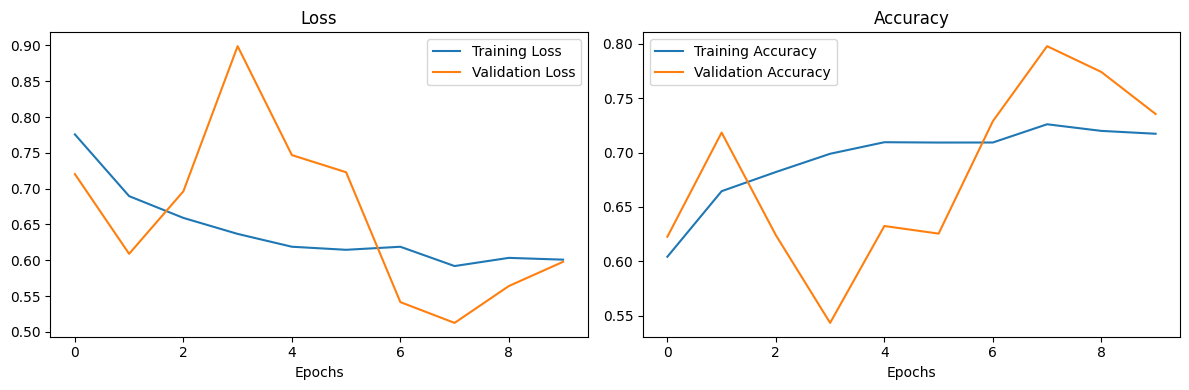

In [15]:
if __name__ == '__main__':
    main()